In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
os.chdir('..')
import rwpropa as rw

## Simulation setup

#### Simulation setup

In [2]:
sim = rw.Simulation()

start simulation


#### Source 

In [3]:
nr_particles = 1*10**3
source_pos = np.array([0.0, 0.0, 0.0], dtype=np.float32)
delta_rho_div_phi = 1 #1/2**0.5 # (delta_r_rho / delta_r_phi)
energy = 3*10**15 # eV
phi = 0.0
pitch_angle = 2*np.pi * 54.74/360 # pitch angle for equal components in all directions
        

source = rw.PointSourceOriented(energy, source_pos, nr_particles, pitch_angle, phi)
sim.add_source(source)
sim.source.get_description()

Description Source:
                The source defines the start conditions of the particles 
                and covers the position, direction, energy, etc

position:  [0. 0. 0.]
number particles:  1000
energy:  3000000000000000  eV
source tpye: PointSourceOriented
pitch angle:  0.955393232541696
phi:  0.0


#### Propagator

In [4]:
nr_steps = 1*10**4
step_size = 0.5*10**10 # [m]
mfp = np.array([2.13*10**12/2.0, 2.13*10**12/2.0, 2.1078*10**12], dtype=np.float32)  # [m]
rms = 1 # Gaus
magnetic_field = rw.OrderedBackgroundField(rms, [0,0,1]).magnetic_field

propagator = rw.AnisotropicPropagator(magnetic_field, mfp, nr_steps, step_size)
#propagator.set_pitch_angle_const(False)
sim.add_propagator(propagator)
sim.propagator.get_description()

Propagator initialized
Description Propagator:
                The propagator is responsible for the movement of the particles. 
                It performs the change of direction and the movement in the respective direction.
                There are two phases:
                 - change direction with probability (see below)
                 - move in all directions
                The movement takes place according to the random walk (RW).

propagation tpye: AnisotropicPropagator
Description Propagator:
                The propagator is responsible for the movement of the particles. 
                It performs the change of direction and the movement in the respective direction.
                There are two phases:
                 - change direction with probability (see below)
                 - move in all directions
                The movement takes place according to the random walk (RW).

coordinates: Cylindrical coordinates
dimensions:  3
pitch angle: constant
particle sp

#### Observer

In [5]:
substeps = [False, False, True] # observe only steps (no substeps)
min_step = 1
max_step = nr_steps
nr_obs_steps = 200

observer = rw.TimeEvolutionObserverLog(min_step, max_step, nr_obs_steps, substeps)

sim.add_observer(observer)
sim.observer.get_description()

Observer initialized
Description Observer:
                The observer defines the conditions for when to write data to the output.

observer tpye: TimeEvolutionObserverLog
spheres:  [-1.]
steps [0:10]:  [ 1  2  3  4  5  6  7  8  9 10]
steps [-11:-1]:  [6294 6593 6905 7232 7575 7934 8309 8703 9115 9547]
nr steps:  154
substeps:  [False False  True]
all_steps:  False


In [6]:
%time sim.run_simulation()
sim.save_data('data/data_sim')

CPU times: user 45.4 s, sys: 129 ms, total: 45.5 s
Wall time: 45.5 s


## Analyze statistics


init statistics plotting class


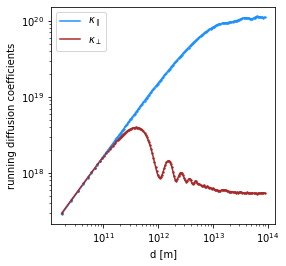

In [7]:
df = pd.read_pickle("data/data_sim.pkl")
df_time_evolution_observer = df.loc[df['radius'] == -1.0]
sta = rw.Statistics(df_time_evolution_observer)
errors = False
df_kappas = sta.plot_diffusion_coefficients(errors)

/home/patrick/.local/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1870: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


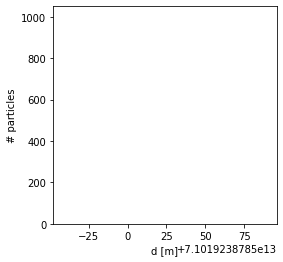

In [8]:
bins = 30
file_name = None
df_kappas = sta.plot_distribution('d', -1, bins, file_name)

In [9]:
df = pd.read_pickle("data/data_sim.pkl")
df

,id,i,d,x,y,z,phi,pitch_angle,radius,sub_step
0,0.0,0.0,0.000000e+00,0.000000e+00,-1.000000e+00,0.000000e+00,NaN,NaN,NaN,NaN
1,0.0,1.0,7.440121e+09,-4.808898e+07,2.356869e+09,1.666306e+09,0.040801,0.955393,-1.0,2.0
2,0.0,2.0,1.488024e+10,-1.922698e+08,4.709815e+09,3.332611e+09,0.081602,0.955393,-1.0,2.0
3,0.0,3.0,2.232036e+10,-4.323117e+08,7.054922e+09,4.998917e+09,0.122403,0.955393,-1.0,2.0
4,0.0,4.0,2.976049e+10,-7.678049e+08,9.388286e+09,6.665222e+09,0.163203,0.955393,-1.0,2.0
...,...,...,...,...,...,...,...,...,...,...
152996,999.0,7934.0,5.902379e+13,-7.530769e+10,-5.505895e+10,5.558571e+12,-64.710831,0.955393,-1.0,2.0
152997,999.0,8309.0,6.181248e+13,-7.283266e+10,5.578636e+10,5.137026e+12,-54.714340,0.955393,-1.0,2.0
152998,999.0,8703.0,6.474246e+13,-4.497223e+10,-5.634363e+10,5.330303e+12,-39.046371,0.955393,-1.0,2.0
152999,999.0,9115.0,6.780630e+13,-1.063755e+11,3.126112e+10,5.530246e+12,-22.562805,0.955393,-1.0,2.0


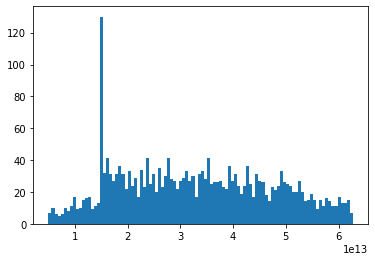

In [20]:
plt.hist(df['d'], bins = 100)
plt.show()

In [11]:
tra = rw.Trajectory(df_time_evolution_observer)
particle_ids = tra.get_particle_ids()
nr_steps = 100
tra.plot_trajectory('x', 'y', 'd', particle_ids[0], nr_steps, None)
tra.plot_trajectory('d', 'z', 'd', particle_ids[0], nr_steps, None)

init trajectory plotting class


IndexError: list index out of range